In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sgnNet import SGN
from dataset import Seq2PointWindows
from training import train_one_epoch, evaluate_mae, main_train , main_train_masked 
from inference import infer_seq2point_timeline, infer_seq2point_timeline_all

from refit_dataloader import load_house_csv


In [ ]:
DATAPATH = r"C:\\Users\\rcper\SGN_NILM\\refit_data\\CLEAN_House2.csv"
APPLIANCE_COL = "Appliance2"
MAX_ROWS = 750000
WIN_LEN = 1024
STRIDE = 32
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
BACKBONE_KIND = "tcn"
PATIENCE = 10
MIN_DELTA = 0.0
RESAMPLE_RULE = "30s"



In [3]:
mains, target, ts = load_house_csv(DATAPATH, appliance_col=APPLIANCE_COL, max_rows = MAX_ROWS,
                                   resample_rule=RESAMPLE_RULE)
print(f"Loaded {len(mains)} samples for House 2")

Loaded 750000 samples for House 2


In [4]:
n = len(mains)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

mains_train, target_train = mains[:train_end], target[:train_end]
mains_val, target_val = mains[train_end:val_end], target[train_end:val_end]
mains_test, target_test   = mains[val_end:], target[val_end:]

train_ds = Seq2PointWindows(mains_train, target_train, win_len=WIN_LEN, stride=STRIDE, train=True)
val_ds   = Seq2PointWindows(mains_val, target_val, win_len=WIN_LEN, stride=STRIDE, train=False)
test_ds  = Seq2PointWindows(mains_test, target_test, win_len=WIN_LEN, stride=STRIDE, train=False)

delta = 50.0 / (train_ds.target_scale + 1e-6)  


pos_rate = float(train_ds.onoff.mean() + 1e-9)  
neg_rate = 1.0 - pos_rate
pos_weight = neg_rate / pos_rate    

pos_weight = min(pos_weight, 8.0) 


Epoch 001 | Train 4.5151 | Val 0.4826 | Val MAE (W): 120.97 | logs: ON 2.955 OFF 0.526 CLS 0.225 | MAE@ON: 175.48 | MAE@OFF: 117.93
Epoch 002 | Train 3.1341 | Val 0.3817 | Val MAE (W): 90.64 | logs: ON 2.034 OFF 0.584 CLS 0.189 | MAE@ON: 136.20 | MAE@OFF: 88.10
Epoch 003 | Train 2.6488 | Val 0.3636 | Val MAE (W): 86.53 | logs: ON 1.714 OFF 0.533 CLS 0.178 | MAE@ON: 124.32 | MAE@OFF: 84.42
Epoch 004 | Train 2.3356 | Val 0.4062 | Val MAE (W): 96.15 | logs: ON 1.504 OFF 0.548 CLS 0.164 | MAE@ON: 114.55 | MAE@OFF: 95.13
Epoch 005 | Train 1.9065 | Val 0.3703 | Val MAE (W): 105.44 | logs: ON 1.222 OFF 0.518 CLS 0.146 | MAE@ON: 116.19 | MAE@OFF: 104.84
Epoch 006 | Train 1.7457 | Val 0.3032 | Val MAE (W): 91.14 | logs: ON 1.113 OFF 0.613 CLS 0.146 | MAE@ON: 106.17 | MAE@OFF: 90.30
Epoch 007 | Train 1.4885 | Val 0.2914 | Val MAE (W): 91.13 | logs: ON 0.941 OFF 0.574 CLS 0.139 | MAE@ON: 98.32 | MAE@OFF: 90.73
Epoch 008 | Train 1.3634 | Val 0.2382 | Val MAE (W): 72.07 | logs: ON 0.858 OFF 0.605 C

c:\Users\rcper\SGN_NILM\training.py:402: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


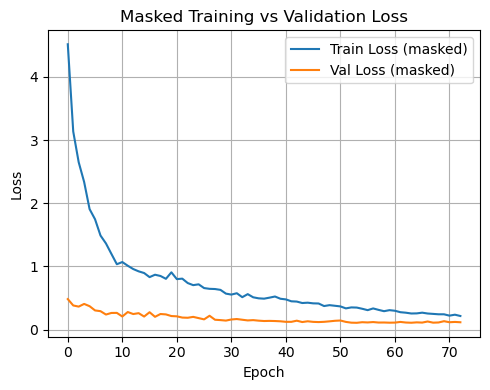

In [5]:
results = main_train_masked(
    mains_train, target_train,
    mains_val,   target_val,
    win_len=WIN_LEN, batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS, kind=BACKBONE_KIND,
    patience=PATIENCE, min_delta=MIN_DELTA, ckpt_path="sgn_best.pt",
    use_scheduler=True, plot=True,
    alpha_on=1.0, alpha_off=0.05, beta_cls=0.25,
    delta_huber=delta,              
    focal_gamma=2.0,
    pos_weight=pos_weight           
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("sgn_best.pt", map_location=device)  # small fix: map to the same device
model = SGN(in_ch=1, hid=64, kind="tcn", out_len=1).to(device)
model.load_state_dict(ckpt["model"])
stats = ckpt["stats"]

power_w, reg_w, cls_p = infer_seq2point_timeline_all(model, mains_test, stats, device)
y_true = target_test  # watts


C:\Users\rcper\AppData\Local\Temp\ipykernel_14508\3868083772.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("sgn_best.pt", map_location=device)  # sma

In [7]:
def smape(a, f):
    denom = (np.abs(a) + np.abs(f)).clip(1e-6, None)
    return (100.0 / len(a)) * np.sum(np.abs(f - a) / denom)

mae_w = np.mean(np.abs(power_w - y_true))
energy_true = y_true.sum()
energy_pred = power_w.sum()
sae = np.abs(energy_pred - energy_true) / (energy_true + 1e-6)
smape_val = smape(y_true, power_w)

print(f"House2 {APPLIANCE_COL} | Test MAE (W): {mae_w:.2f}")
print(f"SAE (energy rel. error): {sae:.4f}")
print(f"sMAPE (%): {smape_val:.2f}")


House2 Appliance2 | Test MAE (W): 11.91
SAE (energy rel. error): 0.1016
sMAPE (%): 95.80


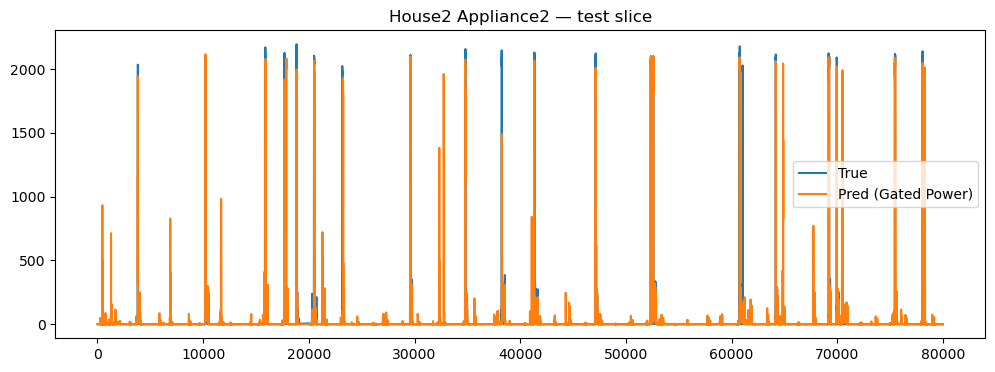

In [8]:
N = min(80000, len(y_true))
plt.figure(figsize=(12,4))
plt.plot(y_true[:N], label="True")
plt.plot(power_w[:N], label="Pred (Gated Power)")
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} — test slice")
plt.show()


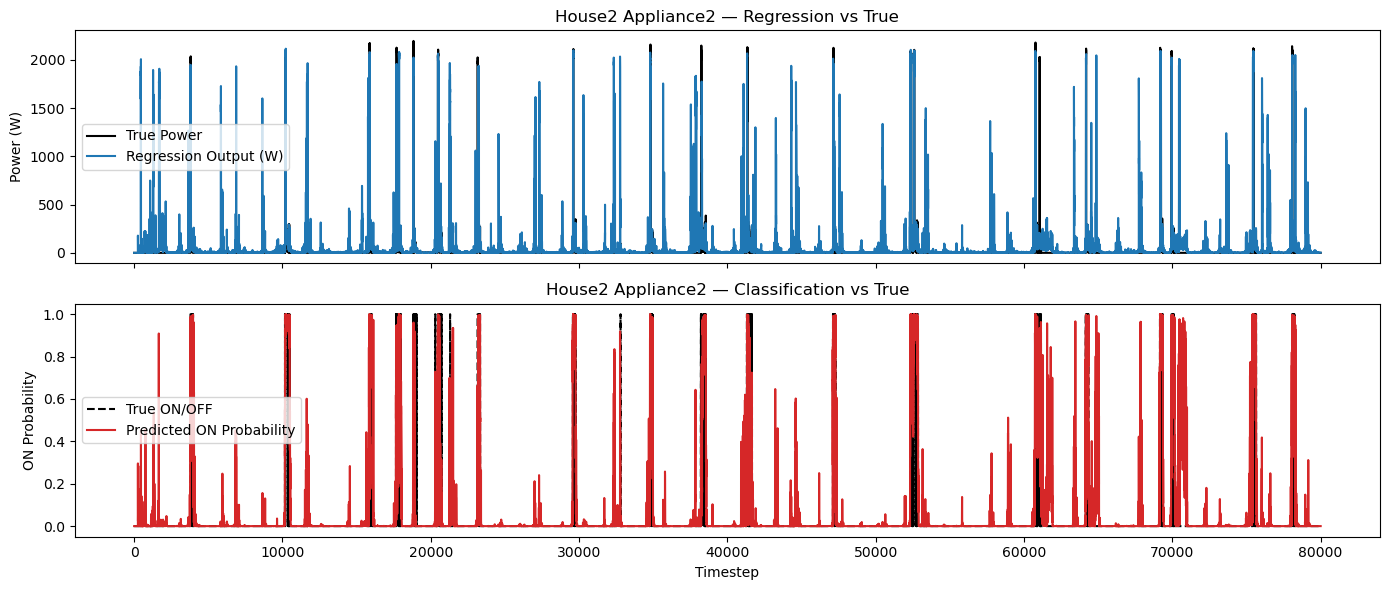

In [9]:
N = min(80000, len(y_true))


on_threshold = 15.0
true_cls = (y_true[:N] > on_threshold).astype(float)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)


ax1.plot(y_true[:N], label="True Power", color="black")
ax1.plot(reg_w[:N], label="Regression Output (W)", color="tab:blue")
ax1.set_ylabel("Power (W)")
ax1.set_title(f"House2 {APPLIANCE_COL} — Regression vs True")
ax1.legend()


ax2.plot(true_cls, label="True ON/OFF", color="black", linestyle="--")
ax2.plot(cls_p[:N], label="Predicted ON Probability", color="tab:red")
ax2.set_ylabel("ON Probability")
ax2.set_xlabel("Timestep")
ax2.set_ylim(-0.05, 1.05)
ax2.set_title(f"House2 {APPLIANCE_COL} — Classification vs True")
ax2.legend()

plt.tight_layout()
plt.show()